In [13]:
# imports and paths
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Conv2D
from tensorflow.keras.optimizers import Adam



SEED = 123

train_dir = "C:\\Users\\LENOVO\\OneDrive - Faculty of Engineering Ain Shams University\\Desktop\\CV Project\\Emotions Data\\train"
test_dir  = "C:\\Users\\LENOVO\\OneDrive - Faculty of Engineering Ain Shams University\\Desktop\\CV Project\\Emotions Data\\test"

TARGET_SIZE = (112, 112)   
BATCH_SIZE = 32
COLOR_MODE = "grayscale"   


In [14]:
#create ImageDataGenerators
train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input, # This scales data to [-1, 1] automatically,
    rotation_range = 15,           
    width_shift_range = 0.12,
    height_shift_range = 0.12,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    brightness_range=[0.8, 1.2],
    fill_mode = 'nearest',
    validation_split = 0.2       # reserve 20% of train data for validation

)

# For validation use the same validation_split but only rescale 
val_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input, 
    validation_split = 0.2
)

# Test generator (for evaluation), no augmentation
test_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input, 

)


In [15]:
# generators
train_generator = train_datagen.flow_from_directory(
    directory = train_dir,
    target_size = TARGET_SIZE,
    color_mode = COLOR_MODE,
    batch_size = BATCH_SIZE,
    class_mode = "categorical",
    subset = "training",
    shuffle = True,
    seed = SEED
)

validation_generator = val_datagen.flow_from_directory(
    directory = train_dir,   # note: validation comes from train_dir using subset='validation'
    target_size = TARGET_SIZE,
    color_mode = COLOR_MODE,
    batch_size = BATCH_SIZE,
    class_mode = "categorical",
    subset = "validation",
    shuffle = False,
    seed = SEED
)

test_generator = test_datagen.flow_from_directory(
    directory = test_dir,
    target_size = TARGET_SIZE,
    color_mode = COLOR_MODE,
    batch_size = BATCH_SIZE,
    class_mode = "categorical",
    shuffle = False
)

print("\nClass mappings:", train_generator.class_indices)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.

Class mappings: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
input_tensor = Input(shape=(112, 112, 1)) # Define the Input (Grayscale)


# We essentially "paint" the grayscale image onto 3 channels so ResNet can see it
x = Conv2D(3, (3, 3), padding='same')(input_tensor)

# Load the ResNet50V2 model, excluding the top layers
base_resnet = ResNet50V2(weights='imagenet', include_top=False, input_shape=(112, 112, 3))

# Freeze the base model
base_resnet.trainable = False

# training=False is CRITICAL here: it keeps BatchNormalization in inference mode
x = base_resnet(x, training=False)

# Custom Head for Emotions
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax', dtype='float32')(x)


model = Model(inputs=input_tensor, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 112, 112, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 3)    │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 4, 4, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,091,173 (91.90 MB)

 Trainable params: 526,373 (2.01 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Save the best model
checkpoint = ModelCheckpoint("Emotions_best2.h5", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')

# Stop if no improvement
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=10, 
                               verbose=1, 
                               restore_best_weights=True)

# Reduce learning rate if stuck
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=4, 
                              verbose=1, 
                              min_lr=1e-6)

callbacks_list = [checkpoint, early_stopping, reduce_lr]

In [11]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=15,  
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks_list
)

Epoch 1/15
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.3081 - loss: 1.8732
Epoch 1: val_accuracy improved from None to 0.41515, saving model to Emotions_best.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 565s 780ms/step - accuracy: 0.3435 - loss: 1.7047 - val_accuracy: 0.4152 - val_loss: 1.5318 - learning_rate: 0.0010
Epoch 2/15
  1/717 ━━━━━━━━━━━━━━━━━━━━ 20:32 2s/step - accuracy: 0.5000 - loss: 1.3962

C:\Users\LENOVO\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.41515
717/717 ━━━━━━━━━━━━━━━━━━━━ 92s 126ms/step - accuracy: 0.5000 - loss: 1.3962 - val_accuracy: 0.4146 - val_loss: 1.5292 - learning_rate: 0.0010
Epoch 3/15
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.3920 - loss: 1.5751
Epoch 3: val_accuracy improved from 0.41515 to 0.43855, saving model to Emotions_best.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 355s 495ms/step - accuracy: 0.3914 - loss: 1.5720 - val_accuracy: 0.4385 - val_loss: 1.4870 - learning_rate: 0.0010
Epoch 4/15
  1/717 ━━━━━━━━━━━━━━━━━━━━ 5:45 483ms/step - accuracy: 0.3438 - loss: 1.4966
Epoch 4: val_accuracy did not improve from 0.43855
717/717 ━━━━━━━━━━━━━━━━━━━━ 37s 50ms/step - accuracy: 0.3438 - loss: 1.4966 - val_accuracy: 0.4378 - val_loss: 1.4875 - learning_rate: 0.0010
Epoch 5/15
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.4032 - loss: 1.5381
Epoch 5: val_accuracy improved from 0.43855 to 0.44920, saving model to Emotions_best.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 359s 501ms/step - accuracy: 0.4047 - loss: 1.5382 - val_accuracy: 0.4492 - val_loss: 1.4471 - learning_rate: 0.0010
Epoch 6/15
  1/717 ━━━━━━━━━━━━━━━━━━━━ 5:29 460ms/step - accuracy: 0.4688 - loss: 1.4294
Epoch 6: val_accuracy did not improve from 0.44920
717/717 ━━━━━━━━━━━━━━━━━━━━ 38s 53ms/step - accuracy: 0.4688 - loss: 1.4294 - val_accuracy: 0.4490 - val_loss: 1.4461 - learning_rate: 0.0010
Epoch 7/15
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.4179 - loss: 1.5218
Epoch 7: val_accuracy improved from 0.44920 to 0.45880, saving model to Emotions_best.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 358s 499ms/step - accuracy: 0.4217 - loss: 1.5142 - val_accuracy: 0.4588 - val_loss: 1.4355 - learning_rate: 0.0010
Epoch 8/15
  1/717 ━━━━━━━━━━━━━━━━━━━━ 5:23 451ms/step - accuracy: 0.5625 - loss: 1.4947
Epoch 8: val_accuracy did not improve from 0.45880
717/717 ━━━━━━━━━━━━━━━━━━━━ 37s 50ms/step - accuracy: 0.5625 - loss: 1.4947 - val_accuracy: 0.4578 - val_loss: 1.4353 - learning_rate: 0.0010
Epoch 9/15
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.4209 - loss: 1.5073
Epoch 9: val_accuracy did not improve from 0.45880
717/717 ━━━━━━━━━━━━━━━━━━━━ 349s 487ms/step - accuracy: 0.4227 - loss: 1.4987 - val_accuracy: 0.4462 - val_loss: 1.4318 - learning_rate: 0.0010
Epoch 10/15
  1/717 ━━━━━━━━━━━━━━━━━━━━ 5:02 423ms/step - accuracy: 0.4375 - loss: 1.5894
Epoch 10: val_accuracy did not improve from 0.45880
717/717 ━━━━━━━━━━━━━━━━━━━━ 35s 48ms/step - accuracy: 0.4375 - loss: 1.5894 - val_accuracy: 0.4485 - val_loss: 1.4279 - learning_rate: 0.0010
E

717/717 ━━━━━━━━━━━━━━━━━━━━ 349s 486ms/step - accuracy: 0.4305 - loss: 1.4915 - val_accuracy: 0.4660 - val_loss: 1.4034 - learning_rate: 0.0010
Epoch 12/15
  1/717 ━━━━━━━━━━━━━━━━━━━━ 5:09 433ms/step - accuracy: 0.3750 - loss: 1.6118
Epoch 12: val_accuracy did not improve from 0.46596
717/717 ━━━━━━━━━━━━━━━━━━━━ 35s 49ms/step - accuracy: 0.3750 - loss: 1.6118 - val_accuracy: 0.4656 - val_loss: 1.4038 - learning_rate: 0.0010
Epoch 13/15
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.4315 - loss: 1.4801
Epoch 13: val_accuracy improved from 0.46596 to 0.47137, saving model to Emotions_best.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 368s 514ms/step - accuracy: 0.4351 - loss: 1.4768 - val_accuracy: 0.4714 - val_loss: 1.3959 - learning_rate: 0.0010
Epoch 14/15
  1/717 ━━━━━━━━━━━━━━━━━━━━ 25:15 2s/step - accuracy: 0.3438 - loss: 1.6680
Epoch 14: val_accuracy improved from 0.47137 to 0.47224, saving model to Emotions_best.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 183s 252ms/step - accuracy: 0.3438 - loss: 1.6680 - val_accuracy: 0.4722 - val_loss: 1.3943 - learning_rate: 0.0010
Epoch 15/15
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.4409 - loss: 1.4732
Epoch 15: val_accuracy improved from 0.47224 to 0.47573, saving model to Emotions_best.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 378s 525ms/step - accuracy: 0.4389 - loss: 1.4734 - val_accuracy: 0.4757 - val_loss: 1.3874 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 15.


In [19]:
from sklearn.utils import class_weight

# 1. extract the class labels from the generator
train_labels = train_generator.classes

# 2. Compute weights (gives higher value to rare classes)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

# 3. Convert to a dictionary for Keras
class_weights_dict = dict(enumerate(class_weights))

print("Class Weights:", class_weights_dict)

Class Weights: {0: 1.0266404434114071, 1: 9.401555464592715, 2: 1.0009587727708533, 3: 0.5684585684585685, 4: 0.826068191627104, 5: 0.8491570541259982, 6: 1.2933160650937552}


In [20]:
history2 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=15,  
    class_weight=class_weights_dict,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks_list
)

Epoch 1/15
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.2360 - loss: 2.0114
Epoch 1: val_accuracy improved from None to 0.31756, saving model to Emotions_best2.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 362s 498ms/step - accuracy: 0.2475 - loss: 1.8904 - val_accuracy: 0.3176 - val_loss: 1.7678 - learning_rate: 0.0010
Epoch 2/15
  1/717 ━━━━━━━━━━━━━━━━━━━━ 5:32 464ms/step - accuracy: 0.3750 - loss: 1.6791

C:\Users\LENOVO\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.31756 to 0.32018, saving model to Emotions_best2.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 38s 52ms/step - accuracy: 0.3750 - loss: 1.6791 - val_accuracy: 0.3202 - val_loss: 1.7675 - learning_rate: 0.0010
Epoch 3/15
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.2839 - loss: 1.8041
Epoch 3: val_accuracy improved from 0.32018 to 0.35056, saving model to Emotions_best2.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 355s 495ms/step - accuracy: 0.2861 - loss: 1.7983 - val_accuracy: 0.3506 - val_loss: 1.6759 - learning_rate: 0.0010
Epoch 4/15
  1/717 ━━━━━━━━━━━━━━━━━━━━ 5:22 451ms/step - accuracy: 0.3125 - loss: 1.4913
Epoch 4: val_accuracy improved from 0.35056 to 0.35545, saving model to Emotions_best2.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 37s 51ms/step - accuracy: 0.3125 - loss: 1.4913 - val_accuracy: 0.3554 - val_loss: 1.6708 - learning_rate: 0.0010
Epoch 5/15
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.2995 - loss: 1.7576
Epoch 5: val_accuracy improved from 0.35545 to 0.37867, saving model to Emotions_best2.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 355s 495ms/step - accuracy: 0.2956 - loss: 1.7606 - val_accuracy: 0.3787 - val_loss: 1.6282 - learning_rate: 0.0010
Epoch 6/15
  1/717 ━━━━━━━━━━━━━━━━━━━━ 5:21 449ms/step - accuracy: 0.2812 - loss: 1.3564
Epoch 6: val_accuracy improved from 0.37867 to 0.37936, saving model to Emotions_best2.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 38s 52ms/step - accuracy: 0.2812 - loss: 1.3564 - val_accuracy: 0.3794 - val_loss: 1.6311 - learning_rate: 0.0010
Epoch 7/15
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.3110 - loss: 1.7272
Epoch 7: val_accuracy did not improve from 0.37936
717/717 ━━━━━━━━━━━━━━━━━━━━ 414s 509ms/step - accuracy: 0.3119 - loss: 1.7266 - val_accuracy: 0.3694 - val_loss: 1.6331 - learning_rate: 0.0010
Epoch 8/15
  1/717 ━━━━━━━━━━━━━━━━━━━━ 5:27 457ms/step - accuracy: 0.3125 - loss: 1.4629
Epoch 8: val_accuracy did not improve from 0.37936
717/717 ━━━━━━━━━━━━━━━━━━━━ 38s 52ms/step - accuracy: 0.3125 - loss: 1.4629 - val_accuracy: 0.3663 - val_loss: 1.6364 - learning_rate: 0.0010
Epoch 9/15
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.3318 - loss: 1.6858
Epoch 9: val_accuracy did not improve from 0.37936

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
717/717 ━━━━━━━━━━━━━━━━━━━━ 374s 522ms/step - accuracy: 0.3190 - loss: 

717/717 ━━━━━━━━━━━━━━━━━━━━ 349s 487ms/step - accuracy: 0.3296 - loss: 1.6751 - val_accuracy: 0.3829 - val_loss: 1.5927 - learning_rate: 2.0000e-04
Epoch 12/15
  1/717 ━━━━━━━━━━━━━━━━━━━━ 5:48 486ms/step - accuracy: 0.3125 - loss: 1.3863
Epoch 12: val_accuracy improved from 0.38286 to 0.38408, saving model to Emotions_best2.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 38s 52ms/step - accuracy: 0.3125 - loss: 1.3863 - val_accuracy: 0.3841 - val_loss: 1.5922 - learning_rate: 2.0000e-04
Epoch 13/15
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.3510 - loss: 1.6384
Epoch 13: val_accuracy improved from 0.38408 to 0.39612, saving model to Emotions_best2.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 364s 508ms/step - accuracy: 0.3515 - loss: 1.6573 - val_accuracy: 0.3961 - val_loss: 1.5690 - learning_rate: 2.0000e-04
Epoch 14/15
  1/717 ━━━━━━━━━━━━━━━━━━━━ 5:31 463ms/step - accuracy: 0.3438 - loss: 1.6596
Epoch 14: val_accuracy did not improve from 0.39612
717/717 ━━━━━━━━━━━━━━━━━━━━ 38s 52ms/step - accuracy: 0.3438 - loss: 1.6596 - val_accuracy: 0.3949 - val_loss: 1.5693 - learning_rate: 2.0000e-04
Epoch 15/15
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3503 - loss: 1.6240
Epoch 15: val_accuracy did not improve from 0.39612
717/717 ━━━━━━━━━━━━━━━━━━━━ 890s 1s/step - accuracy: 0.3474 - loss: 1.6380 - val_accuracy: 0.3670 - val_loss: 1.6090 - learning_rate: 2.0000e-04
Restoring model weights from the end of the best epoch: 13.


In [ ]:
BATCH_SIZE = 16 # for fine-tuning 25 million parameters to update

# Unfreeze the base model variable
base_resnet.trainable = True

#Recompile with a very low learning rate 
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=20,  # more epochs to learn the hard classes
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks_list,
    class_weight=class_weights_dict  
)

Epoch 1/20
 718/1435 ━━━━━━━━━━━━━━━━━━━━ 10:01 839ms/step - accuracy: 0.2943 - loss: 1.8846
Epoch 1: val_accuracy did not improve from 0.39612
1435/1435 ━━━━━━━━━━━━━━━━━━━━ 743s 505ms/step - accuracy: 0.3048 - loss: 1.8091 - val_accuracy: 0.3895 - val_loss: 1.5915 - learning_rate: 1.0000e-05
Epoch 2/20
 718/1435 ━━━━━━━━━━━━━━━━━━━━ 10:00 838ms/step - accuracy: 0.3509 - loss: 1.6685
Epoch 2: val_accuracy improved from 0.39612 to 0.42118, saving model to Emotions_best2.h5


1435/1435 ━━━━━━━━━━━━━━━━━━━━ 641s 446ms/step - accuracy: 0.3507 - loss: 1.6472 - val_accuracy: 0.4212 - val_loss: 1.5005 - learning_rate: 1.0000e-05
Epoch 3/20
 718/1435 ━━━━━━━━━━━━━━━━━━━━ 10:06 845ms/step - accuracy: 0.3814 - loss: 1.5680
Epoch 3: val_accuracy improved from 0.42118 to 0.44034, saving model to Emotions_best2.h5


1435/1435 ━━━━━━━━━━━━━━━━━━━━ 646s 450ms/step - accuracy: 0.3880 - loss: 1.5577 - val_accuracy: 0.4403 - val_loss: 1.4540 - learning_rate: 1.0000e-05
Epoch 4/20
 718/1435 ━━━━━━━━━━━━━━━━━━━━ 9:51 826ms/step - accuracy: 0.4124 - loss: 1.4769
Epoch 4: val_accuracy improved from 0.44034 to 0.45811, saving model to Emotions_best2.h5


1435/1435 ━━━━━━━━━━━━━━━━━━━━ 630s 439ms/step - accuracy: 0.4189 - loss: 1.4766 - val_accuracy: 0.4581 - val_loss: 1.3988 - learning_rate: 1.0000e-05
Epoch 5/20
 718/1435 ━━━━━━━━━━━━━━━━━━━━ 9:42 812ms/step - accuracy: 0.4276 - loss: 1.4329
Epoch 5: val_accuracy improved from 0.45811 to 0.49138, saving model to Emotions_best2.h5


1435/1435 ━━━━━━━━━━━━━━━━━━━━ 621s 433ms/step - accuracy: 0.4383 - loss: 1.4107 - val_accuracy: 0.4914 - val_loss: 1.3146 - learning_rate: 1.0000e-05
Epoch 6/20
 718/1435 ━━━━━━━━━━━━━━━━━━━━ 9:44 815ms/step - accuracy: 0.4555 - loss: 1.3624
Epoch 6: val_accuracy improved from 0.49138 to 0.50148, saving model to Emotions_best2.h5


1435/1435 ━━━━━━━━━━━━━━━━━━━━ 624s 434ms/step - accuracy: 0.4615 - loss: 1.3561 - val_accuracy: 0.5015 - val_loss: 1.2887 - learning_rate: 1.0000e-05
Epoch 7/20
 718/1435 ━━━━━━━━━━━━━━━━━━━━ 9:47 820ms/step - accuracy: 0.4749 - loss: 1.3433
Epoch 7: val_accuracy improved from 0.50148 to 0.51820, saving model to Emotions_best2.h5


1435/1435 ━━━━━━━━━━━━━━━━━━━━ 628s 437ms/step - accuracy: 0.4776 - loss: 1.3162 - val_accuracy: 0.5182 - val_loss: 1.2523 - learning_rate: 1.0000e-05
Epoch 8/20
 718/1435 ━━━━━━━━━━━━━━━━━━━━ 9:49 823ms/step - accuracy: 0.4911 - loss: 1.2907
Epoch 8: val_accuracy improved from 0.51820 to 0.52186, saving model to Emotions_best2.h5


1435/1435 ━━━━━━━━━━━━━━━━━━━━ 629s 438ms/step - accuracy: 0.4902 - loss: 1.2805 - val_accuracy: 0.5219 - val_loss: 1.2447 - learning_rate: 1.0000e-05
Epoch 9/20
 718/1435 ━━━━━━━━━━━━━━━━━━━━ 9:47 820ms/step - accuracy: 0.5061 - loss: 1.2365
Epoch 9: val_accuracy improved from 0.52186 to 0.53353, saving model to Emotions_best2.h5


1435/1435 ━━━━━━━━━━━━━━━━━━━━ 626s 436ms/step - accuracy: 0.5044 - loss: 1.2508 - val_accuracy: 0.5335 - val_loss: 1.2274 - learning_rate: 1.0000e-05
Epoch 10/20
 718/1435 ━━━━━━━━━━━━━━━━━━━━ 9:44 815ms/step - accuracy: 0.5157 - loss: 1.2107
Epoch 10: val_accuracy improved from 0.53353 to 0.54119, saving model to Emotions_best2.h5


1435/1435 ━━━━━━━━━━━━━━━━━━━━ 623s 434ms/step - accuracy: 0.5185 - loss: 1.2031 - val_accuracy: 0.5412 - val_loss: 1.1965 - learning_rate: 1.0000e-05
Epoch 11/20
 718/1435 ━━━━━━━━━━━━━━━━━━━━ 9:49 823ms/step - accuracy: 0.5207 - loss: 1.1790
Epoch 11: val_accuracy improved from 0.54119 to 0.55565, saving model to Emotions_best2.h5


1435/1435 ━━━━━━━━━━━━━━━━━━━━ 628s 437ms/step - accuracy: 0.5245 - loss: 1.1829 - val_accuracy: 0.5557 - val_loss: 1.1675 - learning_rate: 1.0000e-05
Epoch 12/20
 718/1435 ━━━━━━━━━━━━━━━━━━━━ 9:46 818ms/step - accuracy: 0.5443 - loss: 1.1378
Epoch 12: val_accuracy improved from 0.55565 to 0.56018, saving model to Emotions_best2.h5


1435/1435 ━━━━━━━━━━━━━━━━━━━━ 625s 435ms/step - accuracy: 0.5431 - loss: 1.1420 - val_accuracy: 0.5602 - val_loss: 1.1561 - learning_rate: 1.0000e-05
Epoch 13/20
 718/1435 ━━━━━━━━━━━━━━━━━━━━ 9:53 828ms/step - accuracy: 0.5507 - loss: 1.1145
Epoch 13: val_accuracy improved from 0.56018 to 0.56802, saving model to Emotions_best2.h5


1435/1435 ━━━━━━━━━━━━━━━━━━━━ 632s 440ms/step - accuracy: 0.5507 - loss: 1.1092 - val_accuracy: 0.5680 - val_loss: 1.1503 - learning_rate: 1.0000e-05
Epoch 14/20
 718/1435 ━━━━━━━━━━━━━━━━━━━━ 9:46 818ms/step - accuracy: 0.5506 - loss: 1.1378
Epoch 14: val_accuracy improved from 0.56802 to 0.57412, saving model to Emotions_best2.h5


1435/1435 ━━━━━━━━━━━━━━━━━━━━ 626s 436ms/step - accuracy: 0.5573 - loss: 1.0991 - val_accuracy: 0.5741 - val_loss: 1.1274 - learning_rate: 1.0000e-05
Epoch 15/20
 718/1435 ━━━━━━━━━━━━━━━━━━━━ 9:54 829ms/step - accuracy: 0.5715 - loss: 1.0643
Epoch 15: val_accuracy improved from 0.57412 to 0.57864, saving model to Emotions_best2.h5


1435/1435 ━━━━━━━━━━━━━━━━━━━━ 634s 442ms/step - accuracy: 0.5720 - loss: 1.0684 - val_accuracy: 0.5786 - val_loss: 1.1182 - learning_rate: 1.0000e-05
Epoch 16/20
 718/1435 ━━━━━━━━━━━━━━━━━━━━ 9:42 812ms/step - accuracy: 0.5699 - loss: 1.0612
Epoch 16: val_accuracy improved from 0.57864 to 0.58021, saving model to Emotions_best2.h5


1435/1435 ━━━━━━━━━━━━━━━━━━━━ 621s 432ms/step - accuracy: 0.5729 - loss: 1.0549 - val_accuracy: 0.5802 - val_loss: 1.1325 - learning_rate: 1.0000e-05
Epoch 17/20
 718/1435 ━━━━━━━━━━━━━━━━━━━━ 9:43 813ms/step - accuracy: 0.5842 - loss: 1.0301
Epoch 17: val_accuracy improved from 0.58021 to 0.58927, saving model to Emotions_best2.h5


1435/1435 ━━━━━━━━━━━━━━━━━━━━ 622s 433ms/step - accuracy: 0.5841 - loss: 1.0293 - val_accuracy: 0.5893 - val_loss: 1.1124 - learning_rate: 1.0000e-05
Epoch 18/20
 718/1435 ━━━━━━━━━━━━━━━━━━━━ 9:31 798ms/step - accuracy: 0.5888 - loss: 1.0143
Epoch 18: val_accuracy improved from 0.58927 to 0.59519, saving model to Emotions_best2.h5


1435/1435 ━━━━━━━━━━━━━━━━━━━━ 606s 422ms/step - accuracy: 0.5878 - loss: 1.0059 - val_accuracy: 0.5952 - val_loss: 1.0889 - learning_rate: 1.0000e-05
Epoch 19/20
 718/1435 ━━━━━━━━━━━━━━━━━━━━ 9:47 819ms/step - accuracy: 0.6009 - loss: 0.9841
Epoch 19: val_accuracy did not improve from 0.59519
1435/1435 ━━━━━━━━━━━━━━━━━━━━ 626s 436ms/step - accuracy: 0.5985 - loss: 0.9870 - val_accuracy: 0.5945 - val_loss: 1.0851 - learning_rate: 1.0000e-05
Epoch 20/20
 718/1435 ━━━━━━━━━━━━━━━━━━━━ 9:39 808ms/step - accuracy: 0.6009 - loss: 0.9729
Epoch 20: val_accuracy improved from 0.59519 to 0.60111, saving model to Emotions_best2.h5


1435/1435 ━━━━━━━━━━━━━━━━━━━━ 618s 431ms/step - accuracy: 0.6001 - loss: 0.9768 - val_accuracy: 0.6011 - val_loss: 1.0719 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 20.


In [23]:
from tensorflow.keras.optimizers import SGD

# 1. We keep the trained weights (60% accuracy)
# 2. We CHANGE the optimizer to SGD
# 3. CRITICAL: We use a TINY learning rate (1e-4 or 1e-5) to polish, not destroy.
#    Note: SGD often handles slightly larger LRs than Adam, so 1e-4 is usually safe here.
opt = SGD(learning_rate=1e-4, momentum=0.9, nesterov=True)

model.compile(optimizer=opt,
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

print("Starting SGD Polishing (Stage 3)...")

# 4. Train again
history_sgd = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE, 
    epochs=15, 
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks_list,
    class_weight=class_weights_dict
)

Starting SGD Polishing (Stage 3)...
Epoch 1/15
 718/1435 ━━━━━━━━━━━━━━━━━━━━ 9:13 771ms/step - accuracy: 0.6089 - loss: 0.9547
Epoch 1: val_accuracy improved from 0.60111 to 0.60164, saving model to Emotions_best2.h5


1435/1435 ━━━━━━━━━━━━━━━━━━━━ 603s 411ms/step - accuracy: 0.6129 - loss: 0.9491 - val_accuracy: 0.6016 - val_loss: 1.0871 - learning_rate: 1.0000e-04
Epoch 2/15
 718/1435 ━━━━━━━━━━━━━━━━━━━━ 9:23 786ms/step - accuracy: 0.6142 - loss: 0.9476
Epoch 2: val_accuracy did not improve from 0.60164
1435/1435 ━━━━━━━━━━━━━━━━━━━━ 603s 420ms/step - accuracy: 0.6156 - loss: 0.9368 - val_accuracy: 0.6015 - val_loss: 1.0681 - learning_rate: 1.0000e-04
Epoch 3/15
 718/1435 ━━━━━━━━━━━━━━━━━━━━ 9:29 794ms/step - accuracy: 0.6274 - loss: 0.8969
Epoch 3: val_accuracy improved from 0.60164 to 0.60599, saving model to Emotions_best2.h5


1435/1435 ━━━━━━━━━━━━━━━━━━━━ 608s 423ms/step - accuracy: 0.6237 - loss: 0.9077 - val_accuracy: 0.6060 - val_loss: 1.0729 - learning_rate: 1.0000e-04
Epoch 4/15
 718/1435 ━━━━━━━━━━━━━━━━━━━━ 9:32 799ms/step - accuracy: 0.6256 - loss: 0.9128
Epoch 4: val_accuracy improved from 0.60599 to 0.61000, saving model to Emotions_best2.h5


1435/1435 ━━━━━━━━━━━━━━━━━━━━ 611s 425ms/step - accuracy: 0.6277 - loss: 0.9171 - val_accuracy: 0.6100 - val_loss: 1.0636 - learning_rate: 1.0000e-04
Epoch 5/15
 718/1435 ━━━━━━━━━━━━━━━━━━━━ 9:23 787ms/step - accuracy: 0.6272 - loss: 0.9002
Epoch 5: val_accuracy improved from 0.61000 to 0.61435, saving model to Emotions_best2.h5


1435/1435 ━━━━━━━━━━━━━━━━━━━━ 603s 420ms/step - accuracy: 0.6307 - loss: 0.8961 - val_accuracy: 0.6144 - val_loss: 1.0492 - learning_rate: 1.0000e-04
Epoch 6/15
 718/1435 ━━━━━━━━━━━━━━━━━━━━ 9:21 783ms/step - accuracy: 0.6354 - loss: 0.8877
Epoch 6: val_accuracy improved from 0.61435 to 0.61470, saving model to Emotions_best2.h5


1435/1435 ━━━━━━━━━━━━━━━━━━━━ 596s 415ms/step - accuracy: 0.6351 - loss: 0.8979 - val_accuracy: 0.6147 - val_loss: 1.0482 - learning_rate: 1.0000e-04
Epoch 7/15
 718/1435 ━━━━━━━━━━━━━━━━━━━━ 9:25 789ms/step - accuracy: 0.6437 - loss: 0.8938
Epoch 7: val_accuracy did not improve from 0.61470
1435/1435 ━━━━━━━━━━━━━━━━━━━━ 600s 418ms/step - accuracy: 0.6375 - loss: 0.8958 - val_accuracy: 0.6105 - val_loss: 1.0492 - learning_rate: 1.0000e-04
Epoch 8/15
 718/1435 ━━━━━━━━━━━━━━━━━━━━ 9:17 777ms/step - accuracy: 0.6415 - loss: 0.8815
Epoch 8: val_accuracy did not improve from 0.61470
1435/1435 ━━━━━━━━━━━━━━━━━━━━ 595s 415ms/step - accuracy: 0.6442 - loss: 0.8681 - val_accuracy: 0.6126 - val_loss: 1.0517 - learning_rate: 1.0000e-04
Epoch 9/15
 718/1435 ━━━━━━━━━━━━━━━━━━━━ 9:27 792ms/step - accuracy: 0.6463 - loss: 0.8732
Epoch 9: val_accuracy improved from 0.61470 to 0.61522, saving model to Emotions_best2.h5


1435/1435 ━━━━━━━━━━━━━━━━━━━━ 606s 422ms/step - accuracy: 0.6475 - loss: 0.8686 - val_accuracy: 0.6152 - val_loss: 1.0678 - learning_rate: 1.0000e-04
Epoch 10/15
 718/1435 ━━━━━━━━━━━━━━━━━━━━ 9:22 784ms/step - accuracy: 0.6486 - loss: 0.8666
Epoch 10: val_accuracy improved from 0.61522 to 0.61871, saving model to Emotions_best2.h5



Epoch 10: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
1435/1435 ━━━━━━━━━━━━━━━━━━━━ 600s 418ms/step - accuracy: 0.6526 - loss: 0.8548 - val_accuracy: 0.6187 - val_loss: 1.0503 - learning_rate: 1.0000e-04
Epoch 11/15
 718/1435 ━━━━━━━━━━━━━━━━━━━━ 9:17 778ms/step - accuracy: 0.6543 - loss: 0.8375
Epoch 11: val_accuracy improved from 0.61871 to 0.62428, saving model to Emotions_best2.h5


1435/1435 ━━━━━━━━━━━━━━━━━━━━ 595s 415ms/step - accuracy: 0.6545 - loss: 0.8364 - val_accuracy: 0.6243 - val_loss: 1.0384 - learning_rate: 2.0000e-05
Epoch 12/15
 718/1435 ━━━━━━━━━━━━━━━━━━━━ 9:14 774ms/step - accuracy: 0.6599 - loss: 0.8248
Epoch 12: val_accuracy improved from 0.62428 to 0.62446, saving model to Emotions_best2.h5


1435/1435 ━━━━━━━━━━━━━━━━━━━━ 592s 412ms/step - accuracy: 0.6596 - loss: 0.8276 - val_accuracy: 0.6245 - val_loss: 1.0441 - learning_rate: 2.0000e-05
Epoch 13/15
 718/1435 ━━━━━━━━━━━━━━━━━━━━ 9:22 785ms/step - accuracy: 0.6576 - loss: 0.8280
Epoch 13: val_accuracy improved from 0.62446 to 0.62672, saving model to Emotions_best2.h5


1435/1435 ━━━━━━━━━━━━━━━━━━━━ 602s 419ms/step - accuracy: 0.6581 - loss: 0.8271 - val_accuracy: 0.6267 - val_loss: 1.0364 - learning_rate: 2.0000e-05
Epoch 14/15
 718/1435 ━━━━━━━━━━━━━━━━━━━━ 9:22 784ms/step - accuracy: 0.6570 - loss: 0.8189
Epoch 14: val_accuracy did not improve from 0.62672
1435/1435 ━━━━━━━━━━━━━━━━━━━━ 601s 419ms/step - accuracy: 0.6590 - loss: 0.8270 - val_accuracy: 0.6264 - val_loss: 1.0382 - learning_rate: 2.0000e-05
Epoch 15/15
 718/1435 ━━━━━━━━━━━━━━━━━━━━ 9:16 776ms/step - accuracy: 0.6658 - loss: 0.8121
Epoch 15: val_accuracy did not improve from 0.62672
1435/1435 ━━━━━━━━━━━━━━━━━━━━ 594s 414ms/step - accuracy: 0.6652 - loss: 0.8165 - val_accuracy: 0.6260 - val_loss: 1.0429 - learning_rate: 2.0000e-05
Restoring model weights from the end of the best epoch: 13.


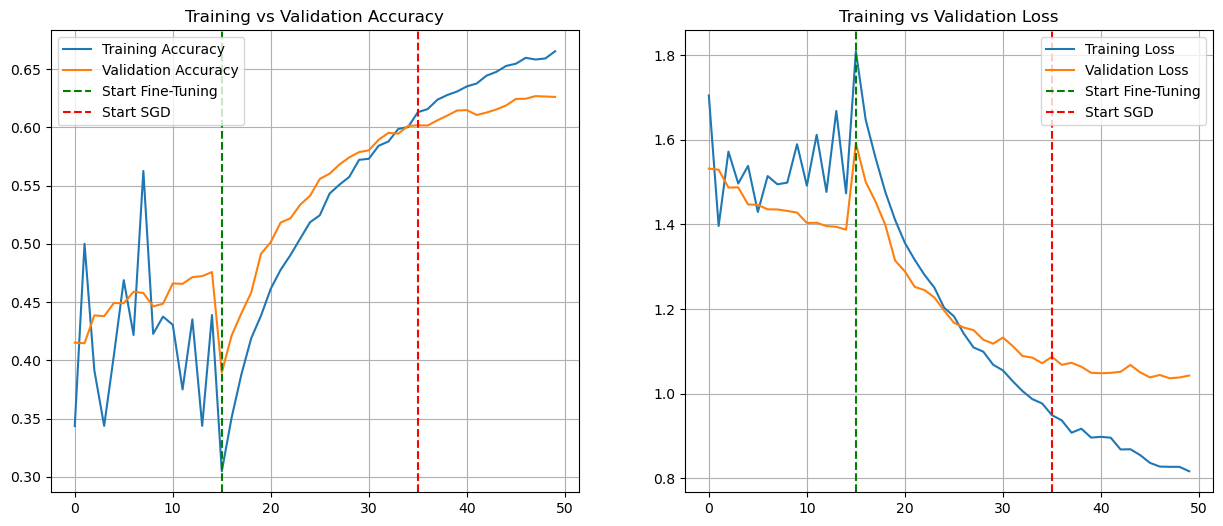

In [24]:
import matplotlib.pyplot as plt

# 1. Combine the histories from all training stages
# Note: If you skipped 'history2' or any stage, just remove it from this list
acc = (history.history['accuracy'] + 
       history_fine.history['accuracy'] + 
       history_sgd.history['accuracy'])

val_acc = (history.history['val_accuracy'] + 
           history_fine.history['val_accuracy'] + 
           history_sgd.history['val_accuracy'])

loss = (history.history['loss'] + 
        history_fine.history['loss'] + 
        history_sgd.history['loss'])

val_loss = (history.history['val_loss'] + 
            history_fine.history['val_loss'] + 
            history_sgd.history['val_loss'])

# 2. Plot Accuracy
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(x=15, color='green', linestyle='--', label='Start Fine-Tuning')
plt.axvline(x=15+20, color='red', linestyle='--', label='Start SGD')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

# 3. Plot Loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(x=15, color='green', linestyle='--', label='Start Fine-Tuning')
plt.axvline(x=15+20, color='red', linestyle='--', label='Start SGD')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.show()

Predicting on Test Data... (This may take a moment)
225/225 ━━━━━━━━━━━━━━━━━━━━ 79s 349ms/step
Final Test Accuracy: 63.23%

Classification Report:

              precision    recall  f1-score   support

       angry       0.53      0.57      0.55       958
     disgust       0.49      0.67      0.57       111
        fear       0.52      0.34      0.41      1024
       happy       0.88      0.82      0.85      1774
     neutral       0.55      0.69      0.61      1233
         sad       0.50      0.47      0.48      1247
    surprise       0.73      0.82      0.77       831

    accuracy                           0.63      7178
   macro avg       0.60      0.63      0.61      7178
weighted avg       0.63      0.63      0.63      7178



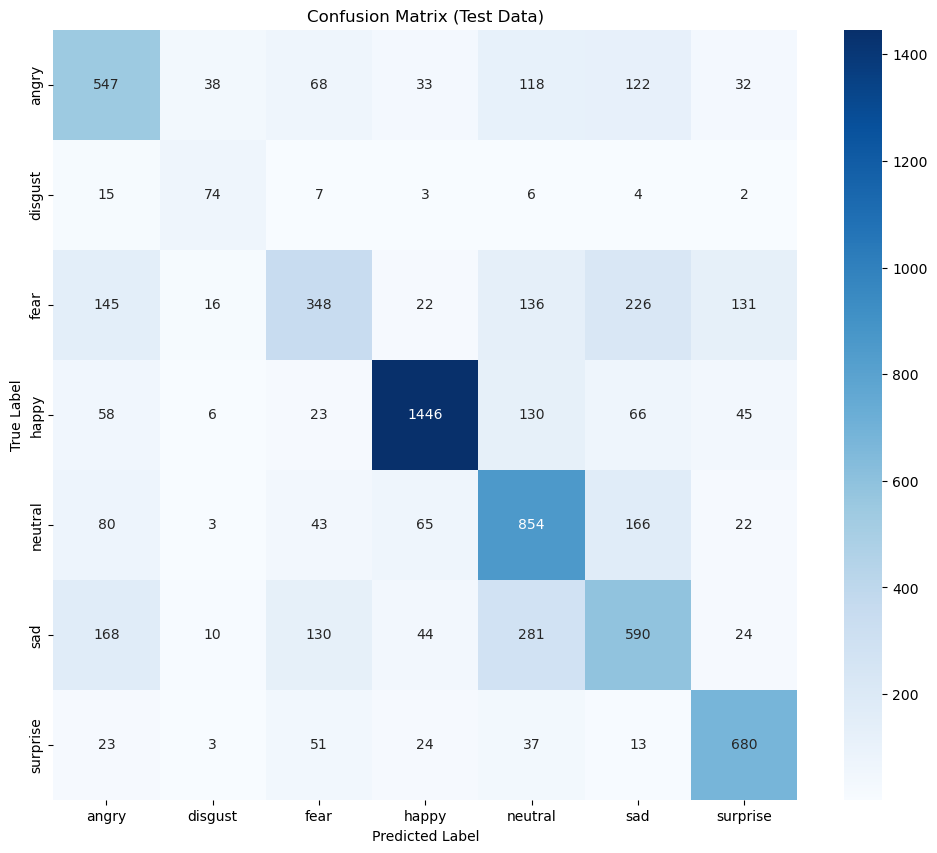

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 1. Reset the test generator to ensure clean order
test_generator.reset()

# 2. Make Predictions
print("Predicting on Test Data... (This may take a moment)")
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# 3. Get True Labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# 4. Calculate Final Test Accuracy
from sklearn.metrics import accuracy_score
final_acc = accuracy_score(true_classes, predicted_classes)
print(f"Final Test Accuracy: {final_acc * 100:.2f}%")

# 5. Classification Report (Precision, Recall, F1-Score)
print("\nClassification Report:\n")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# 6. Plot Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Data)')
plt.show()

In [1]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet_v2 import preprocess_input

# 1. Load your trained model
# Ensure the filename matches your best saved model
model_path = 'Emotions_best2.h5'
print(f"Loading model from {model_path}...")
model = load_model(model_path)
print("✅ Model loaded successfully!")

# 2. Load the Face Detector (Haar Cascade)
# OpenCV's built-in face detector
face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# 3. Define Labels (Must match the order of train_generator.class_indices)
# From your notebook output: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# 4. Start Webcam
cap = cv2.VideoCapture(0)  # 0 is usually the default camera

print("Starting Webcam... Press 'q' to exit.")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to grayscale (Because your model expects 1-channel input)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Detect faces
    faces = face_classifier.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        # Draw box around face
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 255), 2)
        
        # Crop the face area
        roi_gray = gray[y:y+h, x:x+w]
        
        # Resize to 112x112 (Target size used in training)
        try:
            roi_gray = cv2.resize(roi_gray, (112, 112), interpolation=cv2.INTER_AREA)
        except Exception as e:
            continue

        if np.sum([roi_gray]) != 0:
            # Prepare image for the model
            roi = roi_gray.astype('float32')
            
            # Expand dims to match model input: (1, 112, 112, 1)
            roi = np.expand_dims(roi, axis=0) # Add batch dim -> (1, 112, 112)
            roi = np.expand_dims(roi, axis=-1) # Add channel dim -> (1, 112, 112, 1)

            # Preprocess (Scale to range [-1, 1] exactly like training)
            roi = preprocess_input(roi)

            # Predict
            prediction = model.predict(roi, verbose=0)[0]
            max_index = prediction.argmax()
            label = emotion_labels[max_index]
            confidence = prediction[max_index] * 100
            
            # Display text
            label_text = f"{label}"
            cv2.putText(frame, label_text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
        else:
            cv2.putText(frame, 'No Face Found', (20, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Show the video feed
    cv2.imshow('Emotion Detector', frame)

    # Press 'q' to quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Loading model from Emotions_best2.h5...


✅ Model loaded successfully!
Starting Webcam... Press 'q' to exit.
